In [2]:
import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from photutils.aperture import CircularAperture, aperture_photometry


In [3]:
%matplotlib inline


In [4]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#define coordinates	
ra = 201.365
dec = -43.019
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')

In [5]:
# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")


In [6]:
#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
#im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table

In [7]:
im_table.to_table().colnames

NameError: name 'im_table' is not defined

In [8]:
im_table.to_table()['sia_url']

NameError: name 'im_table' is not defined

In [9]:
im_table.to_table()['sia_bp_id']
# i believe this gives us the different bandpasses that you can view the image in. 

NameError: name 'im_table' is not defined

In [10]:
for i in range(len(im_table)):
    print(im_table[i])

NameError: name 'im_table' is not defined

In [11]:
#search for the image in the W3 band image
# using a for loop i assume because it may be printed multiple times maybe?
# i printed it above, it could just be because the ID of the one object is printed 4 times due to there being 4 bandpasses but if you define it at W3 not sure why this is all necessary

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W3':
        break
print(im_table[i].getdataurl())
# ahh yes, so the it runs over the "i" in the dataset until it finds W3 and then stops 
# so using "break" makes the for loop stop after it finds the ID of the object inside of W3
# this is prolly very useful if i am looking for multiple objects.

NameError: name 'im_table' is not defined

In [12]:
#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)

NameError: name 'im_table' is not defined

In [13]:
#extract a cutout and plot it
wcs = WCS(image1[0].header)
wcs


NameError: name 'image1' is not defined

In [14]:
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image1[0].data, pos, (60, 60), wcs=wcs)
wcs = cutout.wcs

NameError: name 'image1' is not defined

In [15]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

#vmax at 4000 gives you the (bulge maybe?) right in the center of it
ax.imshow(cutout.data, origin='lower', vmax = 2300, cmap= 'gray_r')

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"

NameError: name 'wcs' is not defined

<Figure size 640x480 with 0 Axes>

In [16]:
#with fits.open('../Data/image_2MASS-K_s.fits') as image:
 #   image[0].data      # if you dont want to have to close the image again
    

hdul= fits.open('../Data/image_2MASS-K_s.fits')
hdul.info()

Filename: ../Data/image_2MASS-K_s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     112   (512, 701)   float32   


In [17]:
fits1 = fits.getheader('../Data/image_2MASS-K_s.fits')


In [18]:
data = hdul[1]

IndexError: list index out of range

In [19]:
#converting image data from counts to flux 
# encountered problem because this fits file does not have any other hdu's besides primaryHDU
photflam = hdul[1].header['photflam']
exptime = hdr['exptime']
data = data * photflam / exptime
hdul.close()

IndexError: list index out of range

In [20]:
#make sure to run this cell whenever done
hdul.close()

In [21]:
# looking at the WISE specific fits
hdul = fits.open('../Data/image_WISE-Band-1.fits')
hdul.info()

Filename: ../Data/image_WISE-Band-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (437, 369)   float32   


In [22]:
hdr = fits.getheader('../Data/image_WISE-Band-1.fits')
hdr
#the units are in units of intensity "DN"

SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  437 / length of data axis 1                          
NAXIS2  =                  369 / length of data axis 2                          
BUNIT   = 'DN      '           / image pixel units                              
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =             0.000000 / RA at CRPIX1,CRPIX2, J2000.0 (deg)             
CRVAL2  =           -33.317778 / Dec at CRPIX1,CRPIX2, J2000.0 (deg)            
EQUINOX =               2000.0 / Equinox of WCS, (year)                         
CTYPE1  = 'RA---SIN'        

 id xcenter ycenter   aperture_sum_0  
      pix     pix                     
--- ------- ------- ------------------
  1   230.0   230.0 150149.40502063587
150149.40502063587


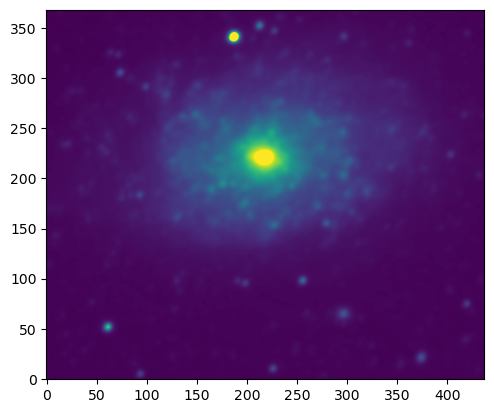

In [25]:
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(230,230,50)] #and , (180,340,50)

#create aperture objects
aperture = [CircularAperture((x,y),r) for (x,y,r) in ROI]


#perform aperture photometry
photo_table = aperture_photometry(phdul, aperture)
print(photo_table)
#results
for i, aperture in  enumerate(aperture):
    flux = photo_table['aperture_sum_0'][i]
print(flux)
hdul.close()

Region 1: Center=(230, 230), Radius=50
Flux: 150149.40502063587
Region 2: Center=(180, 340), Radius=50
Flux: 34562.948759888066


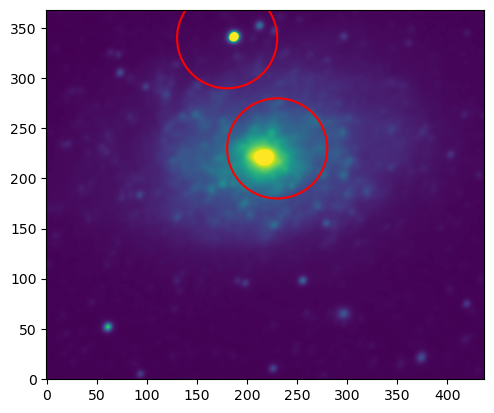

In [37]:
# for multiple apertures
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(230,230,50), (180,340,50)] #and , (180,340,50)

#results
for i, (x,y,r) in  enumerate(ROI):
   #create aperture objects 
    aperture = CircularAperture((x,y),r)
   #perform aperture photometry
    photo_table = aperture_photometry(phdul, aperture)
    #print(photo_table)
    flux = photo_table['aperture_sum'][0]
    print(f"Region {i+1}: Center=({x}, {y}), Radius={r}")
    print(f"Flux: {flux}")

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()
    